In [91]:
from datetime import datetime, timedelta
import pytz

#from plotly import graph_objs as go
#from plotly import offline
#from plotly.subplots import make_subplots

import pandas as pd
import matplotlib.pylab as plt

In [92]:
from django.db.models import F, Max, Min, Sum
from django.db.models.functions import Cast
from django.db.models.fields import DateField
from django.db import connections

from dgas.gas_app import models as md
from dgas.users import models as us

In [104]:
import re

def format_date(query):
    return re.sub(\
        r'[^\'\"]\d{4}\-\d{2}\-\d{2}[^\'\"]{0,1}',
        lambda m: " '"+m.group(0).replace(' ','')+"'::date ",
        str(query)\
    )

In [94]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

/home/isaac/myCode/python/venv_dgas3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [95]:
end = datetime(2019,9,1).date()
init = end - timedelta(days=30)

(init,end)

(datetime.date(2019, 8, 2), datetime.date(2019, 9, 1))

In [96]:
municipio = Municipio.objects.all().first()
municipio

<Municipio: Alberto Adriani>

In [99]:
query_cola = md.Cola.objects\
        .filter(created_at__date__range=(init, end))\
        .annotate(
            id_estacion=F('combustible__estacion'),
            type_car=F('vehiculo__tipo_vehiculo'),
            id_municipio = F('combustible__estacion__municipio_estacion__id'),
            date=Cast('last_modified_at', DateField()),
        ).values(
            'id_municipio',
            'id_estacion',
            'vehiculo',
            'date',
            'cantidad',
            'type_car',

        ).query
query_rebo = md.Rebotado.objects\
        .filter(created_at__date__range=(init, end))\
        .annotate(
            id_estacion=F('combustible__estacion'),
            type_car=F('vehiculo__tipo_vehiculo'),
            id_municipio = F('combustible__estacion__municipio_estacion'),
            date=Cast('last_modified_at', DateField()),
        ).values(
            'id_municipio',
            'id_estacion',
            'date',
            'type_car',
        ).query
query_cont = md.ContadorMedida.objects\
        .filter(created_at__date__range=(init, end))\
        .annotate(
            id_estacion=F('contador__estacion'),
            id_municipio = F('contador__estacion__municipio_estacion'),
            date=Cast('last_modified_at', DateField()),
        ).values(
            'id_municipio',
            'id_estacion',
            'date',
            'cantidad',
        ).query
query_comb  = md.Combustible.objects\
        .filter(created_at__date__range=(init, end))\
        .annotate(
            id_municipio = F('estacion__municipio_estacion')
        ).values(
            'id_municipio',
            'estacion',
            'litros_surtidos_g91',
            'litros_surtidos_g95',
            'litros_surtidos_gsl',
        ).query

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 762 ms


In [107]:
%%time
df_cola = pd.read_sql(format_date(query_cola), connections['default'])
df_rebo = pd.read_sql(format_date(query_rebo), connections['default'])
df_cont = pd.read_sql(format_date(query_cont), connections['default'])
df_comb = pd.read_sql(format_date(query_comb), connections['default'])

CPU times: user 1.56 s, sys: 56 ms, total: 1.62 s
Wall time: 37.5 s


In [148]:
atendidos_dias, tipos_atendidos, stations = None, None, None
stations = md.Estacion.objects.all()[10:]
#stations = md.Estacion.objects.all()

In [149]:
%%time 
count_type = df_cola["type_car"][df_cola["id_municipio"]==municipio.id].value_counts()
count_type

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 27.3 ms


Particular             11429
Carga                     70
Taxi                       5
TP Gasolina                5
Oficial Diario             4
Oficial Interdiario        3
Moto                       1
Name: type_car, dtype: int64

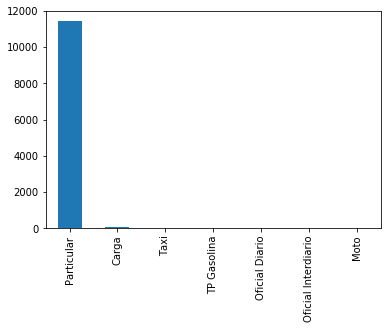

In [150]:
fig = count_type.plot(kind='bar').figure

In [223]:
df_stations = pd.read_sql(format_date(stations.values('id','nombre').query), 
                          connections['default'], index_col='id')
df_stations.head()

,nombre
id,
1,Centenario
24,Chama
21,Diba
27,El Anis
8,El Retorno


In [152]:
%%time
df_dates = pd.DataFrame(pd.date_range(init, end), columns=['day'])
df_dates['count'] = df_dates['day'].apply(
    lambda x: df_cola['date'][(df_cola['date']==x) & (df_cola['id_estacion'].isin(df_stations['id']))].count()
)
df_dates.head()

CPU times: user 10.8 s, sys: 12 ms, total: 10.8 s
Wall time: 11.1 s


,day,count
0,2019-08-02,5725
1,2019-08-03,3863
2,2019-08-04,2453
3,2019-08-05,5491
4,2019-08-06,2798


In [153]:
%%time
df_dates = pd.DataFrame(pd.date_range(init, end), columns=['day'])
df_dates.index = df_dates['day']
df_dates['count'] = df_cola['date'][df_cola['id_estacion'].isin(df_stations['id'])].value_counts()[df_dates['day']]
df_dates.head()

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 110 ms


,day,count
day,,
2019-08-02,2019-08-02,5725
2019-08-03,2019-08-03,3863
2019-08-04,2019-08-04,2453
2019-08-05,2019-08-05,5491
2019-08-06,2019-08-06,2798


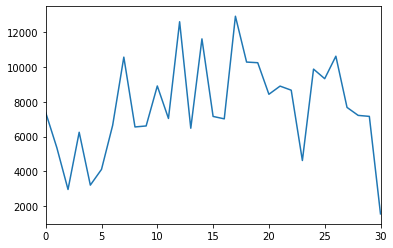

In [20]:
df_dates['count'].plot()

In [22]:
from statsmodels.nonparametric.smoothers_lowess import lowess

result = lowess(df_dates['count'], df_dates['day'])
df_smooth = pd.DataFrame(result, columns=['x','y'])
df_smooth['x'] = pd.to_datetime(df_smooth['x'])

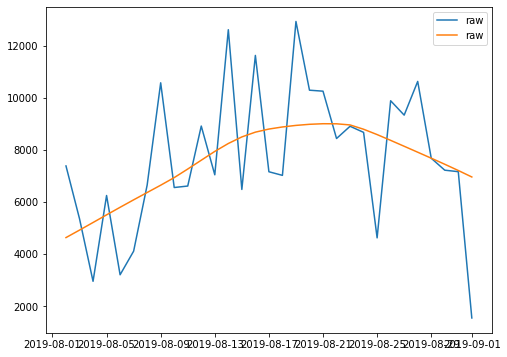

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_dates['day'], df_dates['count'], label="raw")
ax.plot(pd.to_datetime(df_smooth.x), df_smooth.y, label="raw")
plt.legend()

In [ ]:
import plotly.tools as tls
plotly_fig = tls.mpl_to_plotly(fig)
plotly_fig

In [154]:
%%time
df_stations['atendidos'] = df_stations['id'].apply(
    lambda x: df_cola['id_estacion'][df_cola['id_estacion']==x].count()
)

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 119 ms


In [155]:
%%time
df_stations['atendidos'] = df_cola['id_estacion'].value_counts()[df_stations['id']].fillna(0).astype('int')

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 290 ms


/home/isaac/myCode/python/venv_dgas3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [156]:
%%time
df_stations['rebotados'] = df_stations['id'].apply(
    lambda x: df_rebo['id_estacion'][df_rebo['id_estacion']==x].count()
)

CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 86.5 ms


In [157]:
%%time
df_stations['atendidos'] = df_rebo['id_estacion'].value_counts()[df_stations['id']].fillna(0).astype('int')

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 15.5 ms


In [159]:
%%time
df_stations['surtidos'] = df_stations['id'].apply(
    lambda x: df_comb[df_comb['estacion_id']==x][['litros_surtidos_g91','litros_surtidos_g95','litros_surtidos_gsl']].sum().sum()
)

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 255 ms


In [160]:
%%time
df_stations['surtidos'] = df_comb.groupby(['estacion_id'])[
        ['litros_surtidos_g91','litros_surtidos_g95','litros_surtidos_gsl']
    ].sum().sum(axis=1).fillna(0)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.2 ms


In [161]:
%time
df_stations['litros'] = df_cont.groupby(['id_estacion'])['cantidad'].max() - df_cont.groupby(['id_estacion'])['cantidad'].min()
df_stations['litros'] = df_stations['litros'].fillna(0.0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.1 µs


In [162]:
df_stations.head()

,id,nombre,atendidos,rebotados,surtidos,litros
id,,,,,,
1,1,Centenario,565,565,1050.0,0.0
24,24,Chama,352,352,1490.0,0.0
21,21,Diba,493,493,1450.0,0.0
27,27,El Anis,356,356,700.0,0.0
8,8,El Retorno,356,356,1450.0,0.0


In [163]:
count_placa = df_cola['vehiculo_id'].value_counts()

In [190]:
%%time
df_time = pd.DataFrame(count_placa.index[count_placa>9], columns=['placa'])
df_time['tiempo'] = df_time['placa'].apply(
    lambda x: df_cola['date'][df_cola['vehiculo_id']==x].diff(periods=-1).mean().days
)

CPU times: user 4 s, sys: 32 ms, total: 4.03 s
Wall time: 4.03 s


In [212]:
%%time
deltadays = df_cola[df_cola['vehiculo_id'].isin(count_placa.index[count_placa>2])]\
    .sort_values('date').groupby('vehiculo_id')['date'].diff().dt.days

CPU times: user 56.6 s, sys: 1.21 s, total: 57.8 s
Wall time: 2min 1s


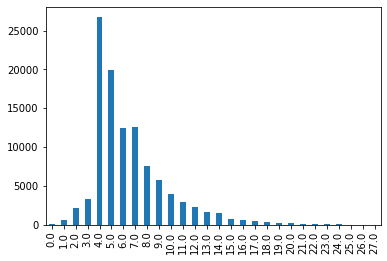

In [213]:
deltadays.index = deltadays.index.astype('int')
deltadays.value_counts().sort_index().plot(kind='bar')

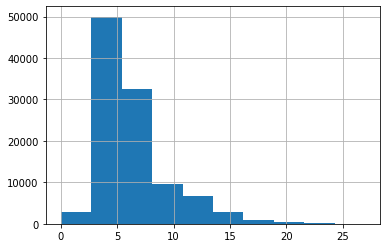

In [215]:
deltadays.hist()

In [ ]:
from dgas.gas_app import models as md
import pandas as pd
from datetime import datetime

init_date = datetime(2019,7,1).date()
end_date = datetime(2019,9,30).date()

placas = md.Cola.objects.filter(created_at__date__range=(init_date, end_date))

df = pd.DataFrame(placas.values('vehiculo_id','created_at'))
df['created_at'] = df['created_at'].dt.date

# Cambiar el nombre de la direccion
df.to_csv(path_or_buf='datos.csv',index=False)